In [1]:
import numpy as np
import scipy.io

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Oct 10 12:13:54 2019',
 '__version__': '1.0',
 '__globals__': [],
 'seizure_files': array([[ 26,  37,  47,  55,  74, 113, 124, 140, 148, 154, 165]],
       dtype=uint8)}

In [2]:
mat_files = []
for pat_idx in range(1, 31):
    mat = scipy.io.loadmat('input/Epilepsiae/Patient_{}/seizure_info.mat'.format(pat_idx))
    mat_files+=['Patient_{}_all/Patient_{}_{}'.format(pat_idx, pat_idx, file_idx) for file_idx in mat['seizure_files'][0]]
print('" "'.join(mat_files))

Patient_1_all/Patient_1_26" "Patient_1_all/Patient_1_37" "Patient_1_all/Patient_1_47" "Patient_1_all/Patient_1_55" "Patient_1_all/Patient_1_74" "Patient_1_all/Patient_1_113" "Patient_1_all/Patient_1_124" "Patient_1_all/Patient_1_140" "Patient_1_all/Patient_1_148" "Patient_1_all/Patient_1_154" "Patient_1_all/Patient_1_165" "Patient_2_all/Patient_2_48" "Patient_2_all/Patient_2_55" "Patient_2_all/Patient_2_59" "Patient_2_all/Patient_2_66" "Patient_2_all/Patient_2_79" "Patient_2_all/Patient_2_81" "Patient_2_all/Patient_2_98" "Patient_2_all/Patient_2_103" "Patient_3_all/Patient_3_68" "Patient_3_all/Patient_3_71" "Patient_3_all/Patient_3_78" "Patient_3_all/Patient_3_80" "Patient_3_all/Patient_3_84" "Patient_3_all/Patient_3_91" "Patient_3_all/Patient_3_94" "Patient_3_all/Patient_3_96" "Patient_3_all/Patient_3_99" "Patient_3_all/Patient_3_142" "Patient_4_all/Patient_4_84" "Patient_4_all/Patient_4_91" "Patient_4_all/Patient_4_100" "Patient_4_all/Patient_4_103" "Patient_4_all/Patient_4_105" "Pat

In [4]:
data = scipy.io.loadmat('input/Epilepsiae/Patient_1_26.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Jul 22 15:52:22 2019',
 '__version__': '1.0',
 '__globals__': [],
 'Offsets': array([[689365]], dtype=int32),
 'Onsets': array([[675249]], dtype=int32),
 'Signals': array([[48.84 , 54.12 , 59.4  , ..., 59.73 , 54.945, 44.88 ],
        [32.67 , 31.845, 31.845, ..., 32.34 , 33.165, 31.185],
        [26.73 , 27.555, 25.245, ..., 28.875, 26.235, 25.245],
        ...,
        [ 1.155, -3.135, -5.775, ...,  1.485,  2.64 ,  3.135],
        [56.1  , 58.41 , 54.12 , ..., 57.09 , 53.79 , 53.79 ],
        [36.465, 37.29 , 39.27 , ..., 31.185, 32.01 , 32.505]]),
 'num_seizures': array([[1]], dtype=uint8),
 'num_t': array(['0075'], dtype='<U4'),
 'patient': array(['pat_102'], dtype='<U7'),
 'EEG_channels': array([[array(['FP1'], dtype='<U3'), array(['FP2'], dtype='<U3'),
         array(['F3'], dtype='<U2'), array(['F4'], dtype='<U2'),
         array(['C3'], dtype='<U2'), array(['C4'], dtype='<U2'),
         array(['P3'], dtype=

In [5]:
signals = data['Signals']
data['Signals'].shape

(24, 921600)

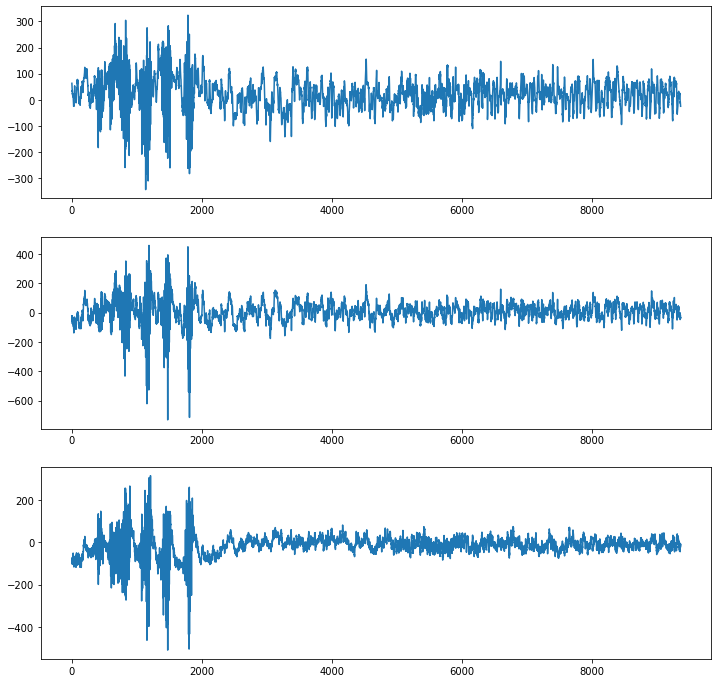

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
plt.subplot(311)
plt.plot(signals[10, 680000:689365])

plt.subplot(312)
plt.plot(signals[12, 680000:689365])

plt.subplot(313)
plt.plot(signals[12, 680000:689365] - signals[10, 680000:689365])

In [8]:
with open("./input/Epilepsiae/non_seizure_list.txt", "r") as f:
    non_seizure_files = f.readlines()
    non_seizure_list = [name.split('_zc.')[0] for name in non_seizure_files]
print(non_seizure_list)


['Patient_10_92.mat', 'Patient_10_93.mat', 'Patient_10_94.mat', 'Patient_10_95.mat', 'Patient_10_96.mat', 'Patient_10_97.mat', 'Patient_10_98.mat', 'Patient_10_99.mat', 'Patient_10_9.mat', 'Patient_1_100.mat', 'Patient_1_101.mat', 'Patient_1_102.mat', 'Patient_1_103.mat', 'Patient_1_104.mat', 'Patient_1_105.mat', 'Patient_1_106.mat', 'Patient_1_107.mat', 'Patient_1_108.mat', 'Patient_1_109.mat', 'Patient_1_10.mat', 'Patient_11_100.mat', 'Patient_11_101.mat', 'Patient_11_102.mat', 'Patient_11_103.mat', 'Patient_11_104.mat', 'Patient_11_106.mat', 'Patient_11_107.mat', 'Patient_11_108.mat', 'Patient_11_109.mat', 'Patient_1_110.mat']


# Features

In [13]:
def zero_crossings(arr):
    """Returns the positions of zero-crossings in the derivative of an array, as a binary vector"""
    return np.diff(np.sign(np.diff(arr))) != 0


def calculateMovingAvrgMeanWithUndersampling_v2(data, winLen, winStep):
    lenSig=len(data)
    index = np.arange(0, lenSig - winLen, winStep)

    segmData = np.zeros(len(index))
    for i in range(len(index)): #-1
        x = data[index[i]:index[i] + winLen]
        segmData[i]=np.mean(x)
    return(segmData)

def polygonal_approx(arr, epsilon):
    """
    Performs an optimized version of the Ramer-Douglas-Peucker algorithm assuming as an input
    an array of single values, considered consecutive points, and **taking into account only the
    vertical distances**.
    """
    def max_vdist(arr, first, last):
        """
        Obtains the distance and the index of the point in *arr* with maximum vertical distance to
        the line delimited by the first and last indices. Returns a tuple (dist, index).
        """
        if first == last:
            return (0.0, first)
        frg = arr[first:last+1]
        leng = last-first+1
        dist = np.abs(frg - np.interp(np.arange(leng),[0, leng-1], [frg[0], frg[-1]]))
        idx = np.argmax(dist)
        return (dist[idx], first+idx)

    if epsilon <= 0.0:
        raise ValueError('Epsilon must be > 0.0')
    if len(arr) < 3:
        return arr
    result = set()
    stack = [(0, len(arr) - 1)]
    while stack:
        first, last = stack.pop()
        max_dist, idx = max_vdist(arr, first, last)
        if max_dist > epsilon:
            stack.extend([(first, idx),(idx, last)])
        else:
            result.update((first, last))
    return np.array(sorted(result))

In [10]:
from scipy import signal
fs = 256

sos = signal.butter(4, [1, 20], 'bandpass', fs=fs, output='sos')
allsigFilt = signal.sosfiltfilt(sos, signals, axis=1)


In [20]:
numCh = 24
num_feat = 6
win_len = 4
EPS_thresh_arr=[16, 32, 64, 128, 256]
length = (allsigFilt.shape[1] // fs) - win_len

# zeroCrossStandard = np.zeros((length, numCh))
# zeroCrossApprox = np.zeros((length, numCh))
zeroCrossFeaturesAll = np.zeros((length, num_feat * numCh))
for ch in range(numCh):
    sigFilt=allsigFilt[ch, :]
    x = np.convolve(zero_crossings(sigFilt), np.ones(fs), mode='same')
    zeroCrossStandard = calculateMovingAvrgMeanWithUndersampling_v2(x, fs * 4, fs)
    zeroCrossFeaturesAll[:, num_feat * ch] = zeroCrossStandard
    for EPSthrIndx, EPSthr in enumerate(EPS_thresh_arr):
        sigApprox = polygonal_approx(sigFilt, epsilon=EPSthr)
        sigApproxInterp = np.interp(np.arange(len(sigFilt)), sigApprox, sigFilt[sigApprox])
        x = np.convolve(zero_crossings(sigApproxInterp), np.ones(fs), mode='same')
        zeroCrossApprox = calculateMovingAvrgMeanWithUndersampling_v2(x, fs *4 , fs)
        zeroCrossFeaturesAll[:, num_feat * ch + EPSthrIndx + 1] = zeroCrossApprox



In [21]:
zeroCrossFeaturesAll.shape

(3596, 144)

# Labeling

In [11]:
import pandas as pd
import json

In [12]:
df_total = pd.DataFrame(columns=['patient', 'file_name', 'length', 'num_seizure', 'channels'])
for file_name in non_seizure_list:
    mat = scipy.io.loadmat(file_name)
    df_total.append({'patient': mat['patient'], 'file_name': file_name, 'num_seizure': mat['num_seizures'],
                     'channels': mat['EEG_channels'], 'length': mat['Signals'].shape[0]})

,patient,file_name,length,num_seizure,channels


In [3]:
df = pd.read_csv('input/Epilepsiae/epilepsiae_labels.csv')
df

,Unnamed: 0,patient,file_name,onsets,offsets,length,channels
0,0,pat_111902,Patient_5_75.mat,[[269824]],[[313662]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d..."
1,1,pat_102,Patient_1_154.mat,[[352376]],[[369568]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d..."
2,2,pat_30002,Patient_13_109.mat,[[602103]],[[610317]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d..."
3,3,pat_58602,Patient_21_146.mat,[[417540]],[[433316]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d..."
4,4,pat_96002,Patient_30_44.mat,[[898866]],[[913707]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d..."
...,...,...,...,...,...,...,...
256,256,pat_103002,Patient_2_55.mat,[[665668]],[[679750]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d..."
257,257,pat_21602,Patient_8_106.mat,[[154818]],[[166889]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d..."
258,258,pat_30002,Patient_13_88.mat,[[431134]],[[456826]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d..."
259,259,pat_55202,Patient_19_100.mat,[[470987]],[[480986]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d..."


In [4]:
df['labels'] = df['length'].apply(lambda x: np.zeros(x//256 - 4, dtype=int))
df['onsets']= df['onsets'].apply(lambda x:json.loads(x.replace('\n', ',')))
df['offsets']= df['offsets'].apply(lambda x:json.loads(x.replace('\n', ',')))

In [5]:
def set_labels(x):
    for seizure_num in range(len(x['onsets'])):
        start = max(x['onsets'][seizure_num][0] // 256 -3, 0)
        end = x['offsets'][seizure_num][0] // 256 + 4
        x['labels'][start:end] = 1

df.apply(set_labels, axis=1)
df

,Unnamed: 0,patient,file_name,onsets,offsets,length,channels,labels
0,0,pat_111902,Patient_5_75.mat,[[269824]],[[313662]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,pat_102,Patient_1_154.mat,[[352376]],[[369568]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,pat_30002,Patient_13_109.mat,[[602103]],[[610317]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,pat_58602,Patient_21_146.mat,[[417540]],[[433316]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,pat_96002,Patient_30_44.mat,[[898866]],[[913707]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
256,256,pat_103002,Patient_2_55.mat,[[665668]],[[679750]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
257,257,pat_21602,Patient_8_106.mat,[[154818]],[[166889]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
258,258,pat_30002,Patient_13_88.mat,[[431134]],[[456826]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
259,259,pat_55202,Patient_19_100.mat,[[470987]],[[480986]],921600,"[[array(['FP1'], dtype='<U3') array(['FP2'], d...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
df['length'].value_counts()

921600    253
919296      1
619776      1
787968      1
859136      1
835840      1
807680      1
738816      1
844288      1
Name: length, dtype: int64

In [7]:
df.to_csv('output/epilepisae_labels.csv')

Training a Random Forest

In [8]:
import pickle

In [9]:
training_set = [x for x in df['file_name'].tolist() if not x.startswith('Patient_1_')]
test_set = [x for x in df['file_name'].tolist() if not x in training_set]
df_file_name = df.set_index('file_name')


In [10]:
X = {'train': np.zeros((0, 144)), 'test': np.zeros((0, 144))}
labels = {'train': np.zeros((0)), 'test': np.zeros((0))}
dataset = {'train': training_set, 'test': test_set}
for mode in ['train', 'test']:
    for t_file in dataset[mode]:
        with open('input/zc/{}_zc.pickle'.format(t_file), 'rb') as pickle_file:
            data = pickle.load(pickle_file)
            X[mode] = np.concatenate((X[mode], data), axis=0)
        y = df_file_name.loc[t_file, 'labels']
        labels[mode] = np.concatenate((labels[mode], y))
X, labels

({'train': array([[27.32714844,  7.11425781,  3.65625   , ...,  2.28613281,
           2.11328125,  0.        ],
         [27.63183594,  6.359375  ,  3.51074219, ...,  2.29003906,
           1.55566406,  0.        ],
         [28.01367188,  4.6171875 ,  3.02734375, ...,  1.72460938,
           0.97460938,  0.        ],
         ...,
         [30.40234375,  0.25      ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [30.34863281,  0.63574219,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [29.93554688,  0.98828125,  0.        , ...,  0.        ,
           0.        ,  0.        ]]),
  'test': array([[ 3.02441406,  1.44140625,  1.31152344, ...,  1.3125    ,
           1.3125    ,  1.0625    ],
         [ 2.37207031,  0.53515625,  0.53515625, ...,  0.48925781,
           0.48925781,  0.25097656],
         [ 1.90136719,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [19.7568

In [11]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=200, random_state=42, verbose=1)
seizure_index = np.where(labels['train'] == 1)[0]
non_seizure_index = np.where(labels['train'] == 0)[0]
for _ in range(15):
    np.random.shuffle(non_seizure_index)
    len_seizure = len(seizure_index)
    train_index = np.concatenate((seizure_index, non_seizure_index[:len_seizure]))
    np.random.shuffle(train_index)
    classifier.fit(X['train'][train_index], labels['train'][train_index])
pred = classifier.predict(X['test'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   59.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels['test'], pred)


array([[33754,  4861],
       [   82,   859]])

# BioTransformer

In [11]:
X = {'train': np.zeros((0, 60, 144)), 'test': np.zeros((0, 60, 144))}
labels = {'train': np.zeros((0, 1)), 'test': np.zeros((0, 1))}
dataset = {'train': training_set, 'test': test_set}
for mode in ['train', 'test']:
    for t_file in dataset[mode]:
        with open('input/zc/{}_zc.pickle'.format(t_file), 'rb') as pickle_file:
            data = pickle.load(pickle_file)
            shape60 = int(data.shape[0] // 60) * 60
            x = np.reshape(data[:shape60,:], newshape=(-1, 60, 144))
            y = np.reshape(df_file_name.loc[t_file, 'labels'][:shape60], newshape=(-1, 60))
            y_agg = np.max(y, axis=1, keepdims=True)
            X[mode] = np.concatenate((X[mode], x), axis=0)
        labels[mode] = np.concatenate((labels[mode], y_agg))
X["train"].shape

KeyboardInterrupt: 

In [12]:
X = {'train': np.zeros((0, 144)), 'test': np.zeros((0, 144))}
labels = {'train': np.zeros((0, 1)), 'test': np.zeros((0, 1))}
valid_labels = {'train': np.zeros(0), 'test': np.zeros(0)}
dataset = {'train': training_set, 'test': test_set}
for mode in ['train', 'test']:
    for t_file in dataset[mode]:
        with open('input/zc/{}_zc.pickle'.format(t_file), 'rb') as pickle_file:
            data = pickle.load(pickle_file)
            X[mode] = np.concatenate((X[mode], data), axis=0)
        y = df_file_name.loc[t_file, 'labels']
        labels[mode] = np.concatenate((labels[mode], np.expand_dims(y,axis=1)))
        valid_index = np.arange(start=valid_labels[mode].shape[0] + 59, stop=valid_labels[mode].shape[0] + y.shape[0])
        valid_labels[mode] = np.concatenate((valid_labels[mode], valid_index))
print(X["train"].shape)
mean_train = np.mean(X["train"])
std_train = np.std(X["train"])
X["train"] = (X["train"] - mean_train) / std_train
X["test"] = (X["test"] - mean_train) / std_train
print(valid_labels["train"].shape)

(895250, 144)
(880500,)


(array([  1051,   1052,   1053, ..., 895039, 895040, 895041]),
 array([0, 0, 0, ..., 0, 0, 0]))

(array([  1051,   1052,   1053, ..., 895039, 895040, 895041]), array([0, 0, 0, ..., 0, 0, 0]))


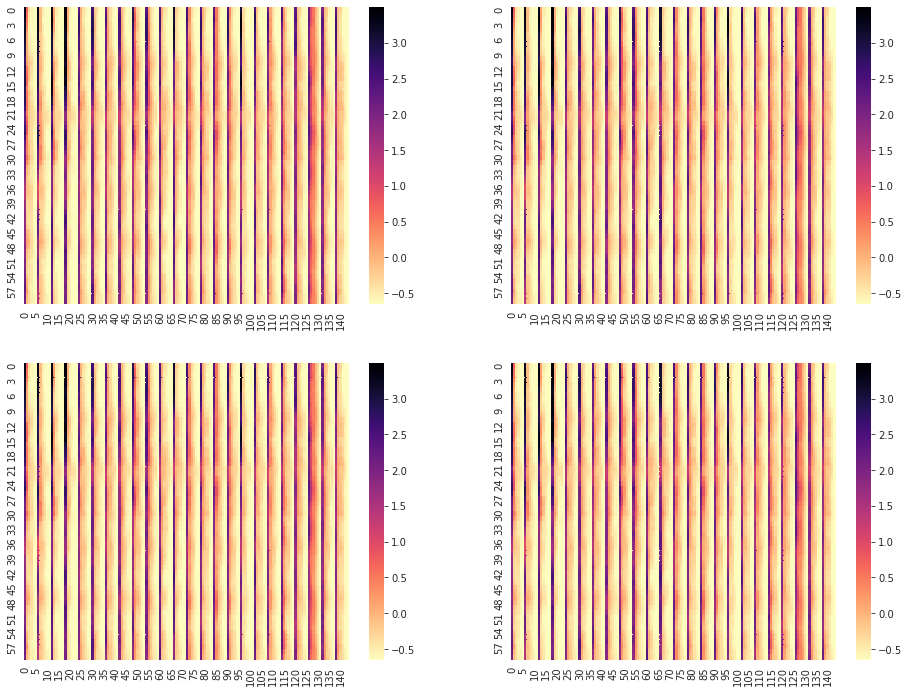

In [16]:
import seaborn as sns
import matplotlib.pylab as plt

mean = np.mean(X["train"])
std = np.std(X["train"])

plt.figure(figsize=(16,12))
plt.subplot(221)
sns.heatmap(X["train"][1040:1100], cmap="magma_r")
plt.subplot(222)

sns.heatmap((X["train"][1040:1100] - mean)/std, cmap="magma_r")
plt.subplot(223)
sns.heatmap(X["train"][1040:1100], cmap="magma_r")
plt.subplot(224)
sns.heatmap(X["train"][1040:1100], cmap="magma_r")
print(np.where(labels["train"] == 1))
# plt.imshow(X["train"][0], cmap="magma_r", cbarlabel="channel value")

In [127]:
labels["train"] = labels["train"].astype(np.int)

/tmp/ipykernel_31665/519519702.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels["train"] = labels["train"].astype(np.int)


In [132]:
labels["train"].dtype

dtype('int64')

In [11]:
from torch import nn, Tensor
import torch
import math
import numpy as np
from torch.nn import TransformerEncoder, TransformerEncoderLayer
torch.manual_seed(1)


class BioTransformer(nn.Module):

    def __init__(self, d_model, n_heads, d_hid, seq_len, n_layers, n_out, device):
        super(BioTransformer, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.device = device
        self.seq_len = seq_len

        encoder_layers = TransformerEncoderLayer(d_model, n_heads, d_hid)
        self.transformer_encoder = TransformerEncoder(encoder_layers, n_layers)
        self.decoder = nn.Linear(d_model, n_out)
        self.sigmoid = nn.Sigmoid()

        self.class_token = nn.Parameter(torch.rand(1, d_model))

    def get_positional_embeddings(self):
        result = torch.ones(self.seq_len, self.d_model)
        for i in range(self.seq_len):
            for j in range(self.d_model):
                result[i][j] = np.sin(i / (10000 ** (j / self.d_model))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / self.d_model)))
        return result

    def forward(self, features):
        n, c, h = features.shape
        tokens = features
        # tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])
        tokens += self.get_positional_embeddings().repeat(n, 1, 1).to(self.device)

        output = self.transformer_encoder(tokens)
        output = self.decoder(output)
        # output = self.sigmoid(output)
        return output


In [12]:
import torch
import matplotlib.pyplot as plt

d_model = 144
n_heads= 2
d_hid = 4*d_model
seq_len = 60
n_layers = 2
n_out = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = BioTransformer().to(device)
model = BioTransformer(d_model=d_model, n_heads=n_heads, d_hid=d_hid, seq_len=seq_len, n_layers=n_layers, n_out=n_out, device=device).to(device)
model



BioTransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=144, out_features=144, bias=True)
        )
        (linear1): Linear(in_features=144, out_features=576, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=576, out_features=144, bias=True)
        (norm1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=144, out_features=144, bias=True)
        )
        (linear1): Linear(in_features=144, out_features=576, bias=True)
        (dropout): Dropo

In [135]:
# torch.save(model, 'output/model60')

In [136]:
# torch.save(model.state_dict(), 'output/model60_state')

## Custom dataset

In [17]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler


class Epilepsy60Dataset(Dataset):
    def __init__(self, x_total, y_total):
        self.x_total = x_total
        self.y_total = y_total

    def __len__(self):
        return self.x_total.shape[0]

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()

        if idx < 59:
            x60 = torch.zeros((60, 144))
        else:
            x60 = self.x_total[idx-59:idx+1, :]

        sample = {'x': x60, 'y': self.y_total[idx]}
        return sample


class ImbalancedDataSampler(Sampler):
    def __init__(self, valid_seizure_indices, valid_non_seizure_indices):
        self.seizure_indices = valid_seizure_indices
        self.non_seizure_indices = valid_non_seizure_indices
        self.num_seizure = len(valid_seizure_indices)
        self.num_non_seizure = len(valid_non_seizure_indices)

    def __iter__(self):
        sampled_non_seizure_indices = torch.randperm(self.num_non_seizure)[:self.num_seizure]
        seizure_non_seizure_cat = torch.cat((self.seizure_indices, self.non_seizure_indices[sampled_non_seizure_indices]), 0)
        return iter(seizure_non_seizure_cat[torch.randperm(2*self.num_seizure)])

    def __len__(self):
        return 2*self.num_seizure





In [14]:
seizure_indices = np.where(labels['train']== 1)[0]
non_seizure_indices = np.where(labels['train'] == 0)[0]
valid_seizures = np.intersect1d(seizure_indices.astype(np.int32),valid_labels["train"].astype(np.int32))
valid_non_seizure = np.intersect1d(non_seizure_indices.astype(np.int32),valid_labels["train"].astype(np.int32))
len(valid_seizures), len(valid_non_seizure)

(21603, 858897)

In [22]:
X_train = X["train"]
Y = labels["train"]
train_set = Epilepsy60Dataset( torch.from_numpy(X_train).float(), torch.from_numpy(Y).float())
sampler = ImbalancedDataSampler(torch.from_numpy(valid_seizures), torch.from_numpy(valid_non_seizure))
train_loader = DataLoader(train_set, batch_size=8, sampler=sampler)

it = iter(train_loader)
first = next(it)
print(first)

{'x': tensor([[[ 1.5848, -0.5543, -0.6481,  ..., -0.6278, -0.6481, -0.6481],
         [ 1.8087, -0.6206, -0.6481,  ..., -0.6481, -0.6481, -0.6481],
         [ 1.8526, -0.6481, -0.6481,  ..., -0.6481, -0.6481, -0.6481],
         ...,
         [ 1.7255, -0.6481, -0.6481,  ..., -0.6481, -0.6481, -0.6481],
         [ 1.7794, -0.6481, -0.6481,  ..., -0.6481, -0.6481, -0.6481],
         [ 1.6883, -0.6481, -0.6481,  ..., -0.6481, -0.6481, -0.6481]],

        [[ 2.0144, -0.1767, -0.4644,  ..., -0.4618, -0.6194, -0.6481],
         [ 1.9844, -0.1261, -0.4198,  ..., -0.4927, -0.6354, -0.6481],
         [ 1.8539, -0.1245, -0.3656,  ..., -0.4538, -0.6469, -0.6481],
         ...,
         [ 1.8035, -0.3429, -0.5223,  ..., -0.5908, -0.6481, -0.6481],
         [ 2.0532, -0.4274, -0.6171,  ..., -0.5906, -0.6481, -0.6481],
         [ 2.1780, -0.4189, -0.5831,  ..., -0.5585, -0.6481, -0.6481]],

        [[ 1.9963, -0.1963, -0.3454,  ..., -0.1590, -0.5247, -0.6481],
         [ 1.8730, -0.0510, -0.3173,  .

In [89]:
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
import torch.nn.functional as F

from tqdm.notebook import tqdm

X_train = X["train"]
Y = labels["train"]
print(Y.dtype)
print(X_train.shape, Y.shape)
train_set = Epilepsy60Dataset( torch.from_numpy(X_train).float(), torch.from_numpy(Y).float())
sampler = ImbalancedDataSampler(torch.from_numpy(valid_seizures), torch.from_numpy(valid_non_seizure))
train_loader = DataLoader(train_set, batch_size=16, sampler=sampler)


 # Training loop
optimizer = Adam(model.parameters(), lr=0.01)
criterion = BCEWithLogitsLoss()
N_EPOCHS = 1

model.train()
for epoch in tqdm(range(N_EPOCHS), desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False):
        x, y = batch['x'], batch['y']
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat[:,-1,:], y)

        train_loss += loss.detach().cpu().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        break

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")


float64
(895250, 144) (895250, 1)


torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])
torch.Size([16, 1]) torch.Size([16, 1])



KeyboardInterrupt: 

In [24]:
trained_model = torch.load('output/model60', map_location=torch.device('cpu'))
trained_model

/home/alireza/.local/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.transformer.TransformerEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/alireza/.local/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/alireza/.local/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.transformer.TransformerEncoderLayer' has changed. you can retrieve the or

BioTransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=144, out_features=144, bias=True)
        )
        (linear1): Linear(in_features=144, out_features=576, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=576, out_features=144, bias=True)
        (norm1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=144, out_features=144, bias=True)
        )
        (linear1): Linear(in_features=144, out_features=576, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear